In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from statsmodels.graphics.factorplots import interaction_plot

plt.style.use('bmh')
plt.rcParams["font.family"] = "Times New Roman"

In [14]:
from contextlib import contextmanager
import pathlib

@contextmanager
def set_posix_windows():
    posix_backup = pathlib.PosixPath
    try:
        pathlib.PosixPath = pathlib.WindowsPath
        yield
    finally:
        pathlib.PosixPath = posix_backup

In [5]:
data_df = pd.DataFrame()

with set_posix_windows():
    data_folder = pathlib.Path().cwd()
    for df in data_folder.glob('**\\raw_data_df.pkl'):
        data_df = pd.concat([data_df, pd.read_pickle(df)],ignore_index=True)

data_df

,model,seed,accelerator,prediction_length,context_multiplier,step_size,hp_tuning,num_epochs,learning_rate,batch_size,...,avg_inference_time_ns,peak_memory,peak_memory_mb,num_mlp_layers,neuron_per_layer,num_channels,num_heads,hidden_dim,variable_dim,dropout_rate
0,deepar,1,gpu,3,3,1,False,200,0.0001,64,...,3.926055e+06,165967812,158.279240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,deepar,2,gpu,3,3,1,False,200,0.0001,64,...,4.034614e+06,165948938,158.261240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,deepar,3,gpu,3,3,1,False,200,0.0001,64,...,3.944756e+06,165948879,158.261184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,deepar,4,gpu,3,3,1,False,200,0.0001,64,...,3.912601e+06,165969958,158.281286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deepar,5,gpu,3,3,1,False,200,0.0001,64,...,3.940739e+06,165973412,158.284580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,tft,19,gpu,3,3,1,False,200,0.0010,256,...,1.809224e+06,255642245,243.799443,NaN,NaN,NaN,4.0,160.0,20.0,0.1
116,tft,29,gpu,3,3,1,False,200,0.0010,256,...,1.791888e+06,255628988,243.786800,NaN,NaN,NaN,4.0,160.0,20.0,0.1
117,tft,10,gpu,3,3,1,False,200,0.0010,256,...,1.763878e+06,255586459,243.746242,NaN,NaN,NaN,4.0,160.0,20.0,0.1
118,tft,20,gpu,3,3,1,False,200,0.0010,256,...,1.800059e+06,255638652,243.796017,NaN,NaN,NaN,4.0,160.0,20.0,0.1


In [6]:
data_df.to_pickle('raw_data_df.pkl')

In [15]:
data_df=pd.read_pickle('raw_data_df.pkl')

In [4]:
data_df['PinballLoss[0.95]'] = data_df['QuantileLoss[0.95]'] // 2
data_df['PinballLoss[0.5]'] = data_df['QuantileLoss[0.5]'] // 2
data_df['qRisk[0.5]'] = data_df['wQuantileLoss[0.5]'] // 2
data_df['qRisk[0.95]'] = data_df['wQuantileLoss[0.95]'] // 2
data_df['qRisk[0.975]'] = data_df['wQuantileLoss[0.975]'] // 2
data_df['qRisk[0.995]'] = data_df['wQuantileLoss[0.995]'] // 2

In [5]:
data_df.columns

Index(['model', 'seed', 'accelerator', 'prediction_length',
       'context_multiplier', 'step_size', 'hp_tuning', 'num_epochs',
       'learning_rate', 'batch_size',
       ...
       'num_heads', 'hidden_dim', 'variable_dim', 'dropout_rate',
       'PinballLoss[0.95]', 'PinballLoss[0.5]', 'qRisk[0.5]', 'qRisk[0.95]',
       'qRisk[0.975]', 'qRisk[0.995]'],
      dtype='object', length=101)

In [11]:
METRICS=['mean_wQuantileLoss', 'sMAPE', 'RMSE', 'QuantileLoss[0.5]', 
         'peak_memory_mb', 'avg_inference_time_ns', 
         'PinballLoss[0.5]', 'PinballLoss[0.95]', 
         'wQuantileLoss[0.5]', 'wQuantileLoss[0.95]', 'wQuantileLoss[0.975]', 'wQuantileLoss[0.995]']
# FACTORS=['learning_rate', 'batch_size','clip_grad', 'num_heads', 'hidden_dim', 'dropout_rate']
FACTORS=['model']

In [8]:
def plot_interaction_plots(x, trace, response, save_fig:bool=False):
    """Draw interaction plots.
    """
    fig, ax = plt.subplots()
    interaction_plot(
        x=x,
        trace=trace,
        response=response,
        # colors=['forestgreen', 'tomato', 'royalblue'],
        ax=ax,
    )
    plt.title(f'Interaction plot for {response.name} vs {x.name} and {trace.name}')
    if save_fig:
        plt.savefig(f'ix_plt_{response.name}_{x.name}_{trace.name}.png')

    plt.close('all')

In [7]:
def plot_metric_vs_factor_boxplot(data_df: pd.DataFrame, metric:str, factor: str, save_fig: bool = False):
    """Plots the maximum fitness vs population archive proportion.
    """
    data = []
    modalities = sorted(data_df[factor].unique())
    grouped = data_df.groupby(by=factor)
    for modality in modalities:
        d = grouped.get_group(modality)[metric].to_list()
        # print(d)
        data.append(list(d))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    # Set x and y axis labels.
    ax.set_xlabel(factor)
    ax.set_ylabel(metric)

    # Set subplot titles.
    ax.set_title(f'{metric} v. {factor}')

    ax.boxplot(data, labels=modalities)
    if save_fig:
        plt.savefig(f'{metric}_vs_{factor}_boxplot.png')

    plt.close('all')

In [32]:
def plot_metric_vs_quntile(data_df: pd.DataFrame, metric:str, models:list, quantiles:list, save_fig: bool = False, markers=['o', '^', 's', 'd', '^', 'x', '*']):
    """Plot the mean and std of metric vs quantile for each model using the errorbar function.
    quantile values for each metric is written in the following format: metric[quantile].
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    # Set x and y axis labels.
    ax.set_xlabel('Quantile')
    ax.set_ylabel(metric)

    # Set subplot titles.
    # ax.set_title(f'{metric} v. Quantile')

    for model, marker in zip(models, markers):
        mean = []
        std = []
        for quantile in quantiles:
            mean.append(data_df[f'{metric}[{quantile}]'][data_df['model']==model].mean())
            std.append(data_df[f'{metric}[{quantile}]'][data_df['model']==model].std())
        ax.errorbar(quantiles, mean, std, marker=marker, label=model)
    ax.set_ylabel('q-Risk')
    ax.set_xlabel('Qauntile')
    ax.legend()
    plt.show()
    if save_fig:
        plt.savefig(f'{metric}_vs_quantile_errorbar.png')

    plt.close('all')


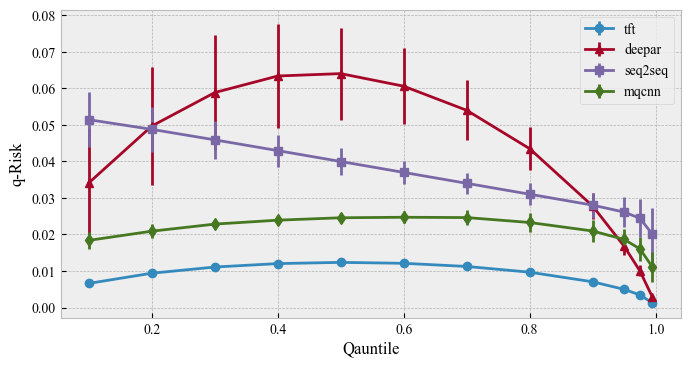

In [33]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.995]
models = ['tft', 'deepar', 'seq2seq', 'mqcnn']
plot_metric_vs_quntile(data_df, 'wQuantileLoss', models, quantiles, save_fig=True)

In [12]:
for metric in METRICS:  
    for factor in FACTORS:
        plot_metric_vs_factor_boxplot(data_df, metric, factor, save_fig=True)

In [11]:
for metric in METRICS:  
    for factor_1, factor_2 in combinations(FACTORS, 2):
        plot_interaction_plots(data_df[factor_1], data_df[factor_2], data_df[metric], save_fig=True)

c:\Users\sepeh\Projects\SMF\.venv\lib\site-packages\statsmodels\graphics\factorplots.py:113: FutureWarning: The provided callable <function mean at 0x0000014BA3BB4670> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()
c:\Users\sepeh\Projects\SMF\.venv\lib\site-packages\statsmodels\graphics\factorplots.py:113: FutureWarning: The provided callable <function mean at 0x0000014BA3BB4670> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()
c:\Users\sepeh\Projects\SMF\.venv\lib\site-packages\statsmodels\graphics\factorplots.py:113: FutureWarning: The provided callable <function mean at 0x0000014BA3BB4670> 